In [2]:
import librosa
import numpy as np
import os
import copy

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# setting up the data directory
DATA_DIR="cats_dogs/"

In [5]:
class Sound:
    def __init__(self, filePath, cat, spec = None):
        self.filePath = filePath
        self.cat = cat
        self.spec = spec 

    def __str__(self):
        return f"Sound(filePath={self.filePath}, cat={self.cat}, spec={self.spec}, melSpec={self.melSpec})"
    

In [6]:
audiofiles = []
files = [f for f in os.listdir(DATA_DIR) if os.path.isfile(os.path.join(DATA_DIR, f))]
for file in files:
    isCat = file.split("_")[0] == "cat"
    audiofiles.append(Sound(filePath=DATA_DIR+file ,cat=isCat))

In [7]:
y, sr = librosa.load(audiofiles[0].filePath)


In [10]:
sumDurations  = 0
sumFiles = 0
for audiofile in audiofiles:
    y, sr = librosa.load(audiofile.filePath)
    sumDurations += librosa.get_duration(y =y, sr=sr)
    sumFiles += 1
print(sumDurations/sumFiles)
TARGETDURATION = np.ceil(sumDurations/sumFiles)
TARGETDURATION

6.939857887800129


7.0

we now know that the mean duration of an audio sample ist 7.2 seconds so we will try to normalize all audiofiles

We need to normalize the shape of our audio file so we make every sound 8 seconds long

The function below creates a mel spectogram for given audio input. The input has to be the path of the input. THe audiofile has to be a tupel with the path to the soundfile first and the class second.

In [11]:
def getMelSpecLabel(audiofile:Sound):
    y, sr = librosa.load(audiofile.filePath)
    # Passing through arguments to the Mel filters
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                        fmax=8000)
    audiofile.spec = librosa.power_to_db(S, ref=np.max)

In [12]:
def plotMel(audiofile:Sound):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(audiofile.spec, x_axis='time',
                            y_axis='mel', 
                            fmax=8000, ax=ax)
    if audiofile.cat:
        ax.set(title="Cat")
    else:
        ax.set(title="Dog")
    fig.colorbar(img, ax=ax, format='%+2.0f dB')

ich würde gerne die verteilung der Längen der audiodaten kennen


In [13]:
for audiofile in audiofiles:
    y, sr = librosa.load(audiofile.filePath)
    target_samples = TARGETDURATION * sr
    #if((target_samples - len(y)) <100 and target_samples - len(y)>-100):
    if (len(y) > target_samples):
        print(str(len(y)) + "|" + str(target_samples))

298945|154350.0
260190|154350.0
264600|154350.0
334984|154350.0
231525|154350.0
264600|154350.0
213885|154350.0
264600|154350.0
257985|154350.0
175456|154350.0
185220|154350.0
238140|154350.0
264600|154350.0
262395|154350.0
264600|154350.0
229247|154350.0
163453|154350.0
264600|154350.0
264600|154350.0
264600|154350.0
187161|154350.0
209475|154350.0
232373|154350.0
257985|154350.0
264600|154350.0
333609|154350.0
154527|154350.0
256321|154350.0
264600|154350.0
260190|154350.0
264600|154350.0
264600|154350.0
264600|154350.0
264600|154350.0
238140|154350.0
264600|154350.0
222970|154350.0
207006|154350.0
246960|154350.0
205001|154350.0
224381|154350.0
242550|154350.0
264600|154350.0
191374|154350.0
227115|154350.0
255780|154350.0
225415|154350.0
264600|154350.0
251370|154350.0
379265|154350.0
231525|154350.0
181075|154350.0
264600|154350.0
260190|154350.0
242550|154350.0
262395|154350.0
264600|154350.0
260190|154350.0
259430|154350.0
192894|154350.0
264600|154350.0
264600|154350.0
264600|1

[[-58.61299  -41.643627 -37.16182  ... -65.08957  -64.84053  -63.39923 ]
 [-65.794785 -56.060455 -54.005676 ... -66.68897  -62.772957 -58.957684]
 [-74.54154  -61.993736 -55.103016 ... -64.10698  -59.95697  -57.796425]
 ...
 [-76.15093  -63.55017  -53.9777   ... -80.       -80.       -80.      ]
 [-76.17961  -64.40683  -56.657074 ... -80.       -80.       -80.      ]
 [-80.       -78.376816 -70.65631  ... -80.       -80.       -80.      ]]


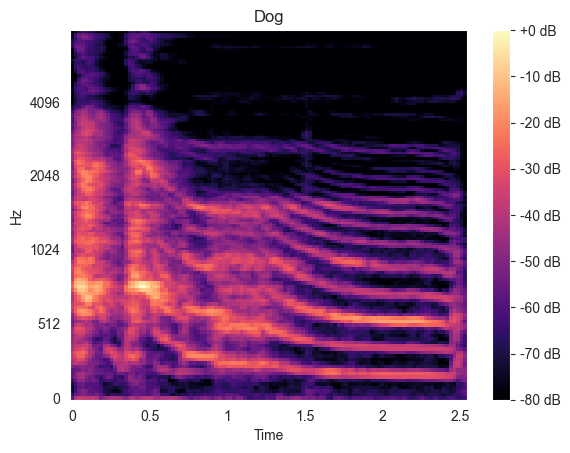

In [14]:
num = 3
processedData = getMelSpecLabel(audiofile=audiofiles[num])
print(audiofiles[num].spec)
plotMel(audiofiles[num])
#print(processedData[0].shape)

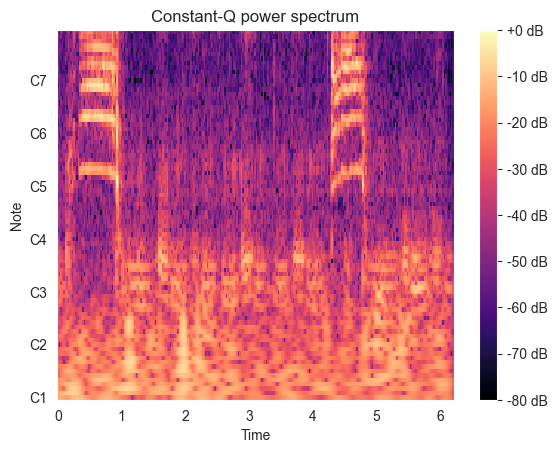

In [16]:
y, sr = librosa.load(audiofiles[0].filePath)
C = np.abs(librosa.cqt(y, sr=sr))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")


AttributeError: 'NoneType' object has no attribute 'dtype'

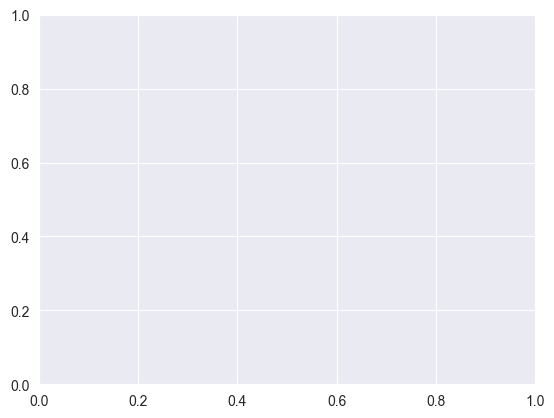

Next we have to Resize all Spectogramms to the same input shape. By converting into a mel spectogramm every Spectotramm has a heigt (first dimension) of 128, the second demension should have a length of 311

In [11]:
def pad_resize(audiofile:Sound, width:int):
    if audiofile.spec.shape[1] > width:
      audiofile.spec = audiofile.spec[:, :width]
    else:
        counter = 0
        while audiofile.spec.shape[1] < width:
            new_column = np.array([audiofile.spec[:, counter]]).reshape(128,1)
            audiofile.spec = np.hstack((audiofile.spec, new_column))
            counter += 1  
  

0

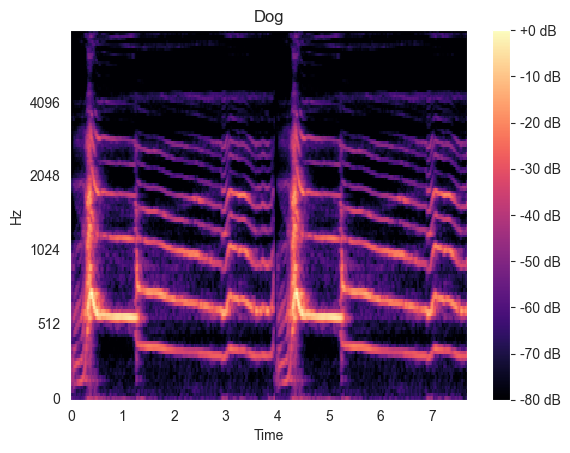

In [25]:
def add_noise(sound:Sound):
    #entscheidet ob vertikal oder horizontal verändert werden soll
    
    if np.random.randint(0,2) == 1:
        pass
    else:
        pass
    noise_level = np.random.randint(10, 26)
    return np.random.randint(0,1)

num = 1
getMelSpecLabel(audiofiles[num])
pad_resize(audiofiles[num], 331)
plotMel(audiofiles[num])
add_noise(audiofiles[num])


In [24]:
num = 3
getMelSpecLabel(audiofiles[num])
pad_resize(audiofiles[num], 331)

#plotMel((spec, processedData[1]))


In [14]:
sameLengthMel = []
label = []
for audiofile in audiofiles:
    getMelSpecLabel(audiofile=audiofile)
    pad_resize(audiofile=audiofile, width=331)
    sameLengthMel.append(audiofile.spec.reshape((128,331,1)))
    if audiofile.cat:
        label.append("Cat")
    else:
        label.append("Dog")
features = np.array(sameLengthMel)
labels =np.array(label)

In [15]:
features[0].shape

(128, 331, 1)

## The Model

In [16]:
model = keras.Sequential(layers=[
        keras.layers.InputLayer(input_shape=features[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(2, activation=keras.activations.softmax)
    ])
model.compile(optimizer=keras.optimizers.legacy.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 331, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 165, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 165, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 82, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 83968)             0         
                                                                 
 dense (Dense)               (None, 64)                5

In [17]:
def one_hot(array):
    unique, inverse = np.unique(labels, return_inverse=True)
    onehot = np.eye(unique.shape[0])[inverse]
    return onehot
encoded_labels = one_hot(labels)

In [18]:
# Set parameters for data splitting and training
TEST_SIZE = 0.2
BATCH_SIZE = 64
EPOCHS = 50

# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=TEST_SIZE)

# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/50
3/3 [==============================] - 1s 174ms/step - loss: 308.6998 - accuracy: 0.4545 - val_loss: 23.7725 - val_accuracy: 0.5333
Epoch 2/50
3/3 [==============================] - 0s 146ms/step - loss: 55.4325 - accuracy: 0.6250 - val_loss: 62.1349 - val_accuracy: 0.5333
Epoch 3/50
3/3 [==============================] - 0s 147ms/step - loss: 25.7888 - accuracy: 0.6023 - val_loss: 22.1310 - val_accuracy: 0.4667
Epoch 4/50
3/3 [==============================] - 0s 145ms/step - loss: 19.0808 - accuracy: 0.3750 - val_loss: 4.5203 - val_accuracy: 0.5333
Epoch 5/50
3/3 [==============================] - 0s 152ms/step - loss: 3.6242 - accuracy: 0.6307 - val_loss: 4.7445 - val_accuracy: 0.5333
Epoch 6/50
3/3 [==============================] - 0s 150ms/step - loss: 1.9432 - accuracy: 0.7614 - val_loss: 0.6874 - val_accuracy: 0.7556
Epoch 7/50
3/3 [==============================] - 0s 148ms/step - loss: 0.5722 - accuracy: 0.7670 - val_loss: 0.5095 - val_accuracy: 0.7778
Epoch 8/50
3

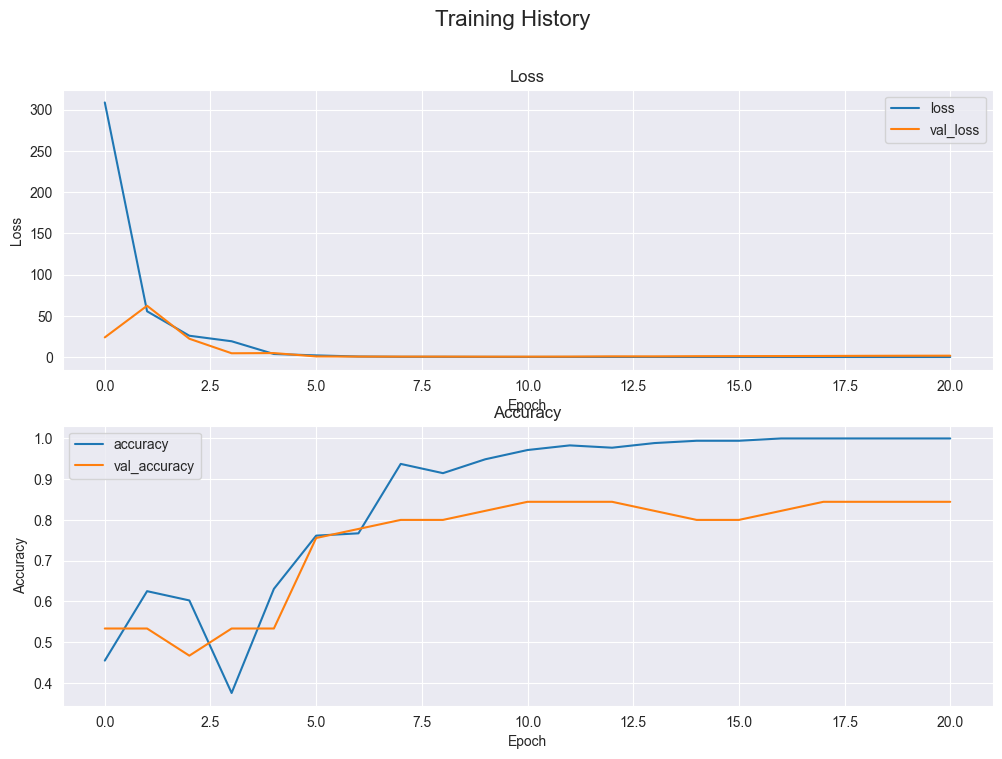

In [19]:
# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

2/2 [==============================] - 0s 26ms/step


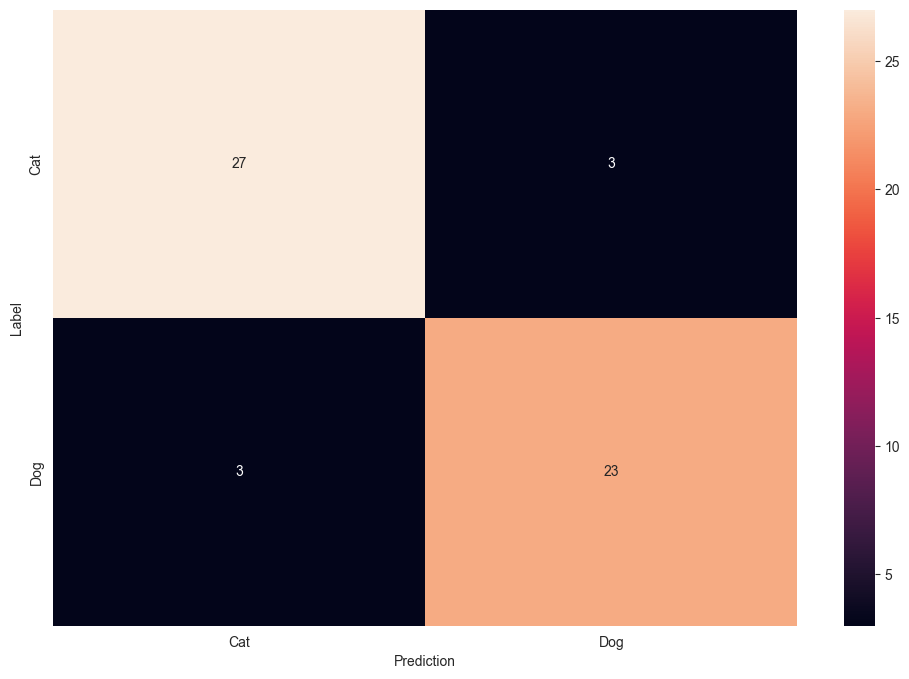

In [20]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [21]:
def predict(audio:Sound):
    getMelSpecLabel(audio)
    pad_resize(audio, 331)
    audio.spec = audio.spec.reshape((1,128,331,1))
    return model.predict(x=sound1.spec)

In [22]:
sound1 = Sound(DATA_DIR + "cat_3.wav", True)
print(predict(sound1))

1/1 [==============================] - 0s 15ms/step
[[0.85498816 0.14501183]]
